In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import h5py

import calculation.MeanFieldv2 as MFv2
import calculation.CurrentMeirv2 as CsMv2
import calculation.SusceptibilitySimpv2 as Susceptv2
import settings.Constants as const


In [2]:
## Initial Conditions
phiConstantInit = 0.5
phiLambdaInit = 0.9

In [3]:

Tvalue = 1e-6
couplingValue = 0.7
voltageSamples = np.array([0.0, 1.0782277033434142, 1.428227703343414, 1.778227703343414])
lambdaValue = 0.0

phiSpace = np.zeros(len(voltageSamples))

for i in range(voltageSamples.shape[0]):
    result = scipy.optimize.root(MFv2.computeMFLambda, phiConstantInit, args=(lambdaValue, voltageSamples[i], Tvalue, MFv2.Impy, couplingValue), method='lm', tol=1e-6)
    phiSpace[i] = result.x[0]

print(list(phiSpace))

[0.0, 0.0, 0.0, 0.0]


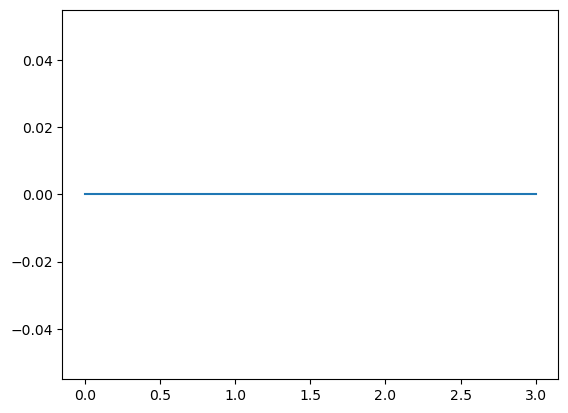

In [4]:

plt.plot(phiSpace)

In [5]:
TSpace = np.linspace(1e-5, 0.5, 30)
couplingValue = 0.7
voltageValue = 0.0
lambdaValue = 1.0

phiSpace2 = np.zeros(len(TSpace))

for i in range(TSpace.shape[0]):
    result = scipy.optimize.root(MFv2.computeMFLambda, phiConstantInit, args=(lambdaValue, voltageValue, TSpace[i], MFv2.Impy, couplingValue), method='lm', tol=1e-6)
    phiSpace2[i] = result.x[0]
    # print("result: ", result)

# print(list(phiSpace2))

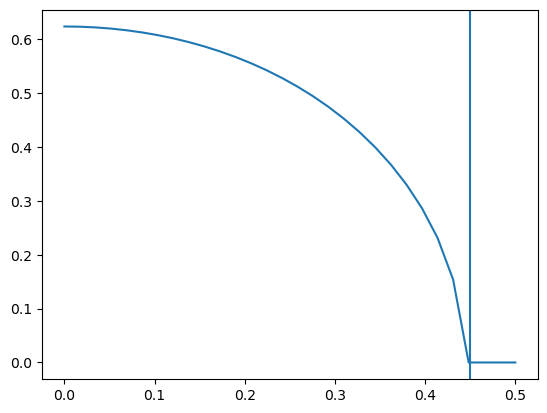

In [6]:
plt.plot(TSpace, phiSpace2)
plt.axvline(x=0.45)

In [ ]:

TSpace = np.array([1e-5, 2e-1, 0.45, 0.5])
couplingValue = 0.7
voltageValue = 0.0
lambdaValue = 1.0

phiSpace2 = np.zeros(len(voltageSamples))

for i in range(TSpace.shape[0]):
    result = scipy.optimize.root(MFv2.computeMFLambda, phiConstantInit, args=(lambdaValue, voltageValue, TSpace[i], MFv2.Impy, couplingValue), method='lm', tol=1e-6)
    phiSpace2[i] = result.x[0]
    # print("result: ", result)

print(list(phiSpace2))

In [ ]:
plt.plot(TSpace,phiSpace2, '.')

In [ ]:

#### shot noise and effective temperature (zero frequency) as as a function of V and T


couplingValue = 0.7
voltageNewSpace = np.linspace(1e-4, 1.8, 38)
TNewSpace = np.linspace(1e-4, 0.5, 38)
lambdaSamples = np.array([1.0])

## Initial Conditions
phiConstantInit = 0.5
phiLambdaInit = 0.9



In [ ]:
def computeSaddlePoints(lambdaSamples, Tvalue, voltageSpacePlot, pbar=None):
    saddle_points = np.zeros(len(voltageSpacePlot), dtype=float)
    lambdaValue = lambdaSamples[0]
    for i in range(len(voltageSpacePlot)):
        voltageValue = voltageSpacePlot[i]
        result = scipy.optimize.root(MFv2.computeMFLambda, phiConstantInit, args=(lambdaValue, voltageValue, Tvalue, MFv2.Impy, couplingValue), method='lm', tol=1e-6)
        saddle_points[i] = result.x[0]
            
        if pbar is not None:
            pbar.update(1)
    
    return saddle_points


phi_voltage_T = np.zeros((len(TNewSpace), len(voltageNewSpace)), dtype=float)
pbar = tqdm(total=len(TNewSpace)*len(voltageNewSpace), desc='Computing phi(T)')

for i in range(len(TNewSpace)):
    Tvalue = TNewSpace[i]
    phi_voltage_T[i,:] = computeSaddlePoints(lambdaSamples, Tvalue, voltageNewSpace, pbar=pbar)
pbar.close()


In [ ]:

domainSpace = np.zeros((phi_voltage_T.size, 5), dtype=float)

counter = 0
for i in range(len(TNewSpace)):
    for j in range(len(voltageNewSpace)):
        counter = i * len(TNewSpace) + j
        domainSpace[counter, :] = [lambdaValue, voltageNewSpace[j], couplingValue, phi_voltage_T[i,j], TNewSpace[i]]


In [ ]:
plt.figure()
for i in range(phi_voltage_T.shape[0]):
    plt.plot(phi_voltage_T[i])

In [ ]:

#####* lambda = 1 (lambda zero is zero the interacting component)
omegaSpace = np.array([-1e-3, 1e-5, 1e-3])
DRDataOne = np.zeros((domainSpace.shape[0], omegaSpace.shape[0]), dtype=complex)
DKDataOne = np.zeros((domainSpace.shape[0], omegaSpace.shape[0]), dtype=complex)
    
pbar = tqdm(total=domainSpace.shape[0], desc='Bosonic Green Functions')
for i in range(domainSpace.shape[0]):
    lambdaValue, voltageValue, couplingValue, phiValue, Tvalue = domainSpace[i,:]

    vecPiR = Susceptv2.computePiR(omegaSpace, lambdaValue, phiValue, voltageValue, couplingValue, Tvalue=Tvalue)
    if Tvalue < const.Tvalue_ref:
        vecPiK = Susceptv2.computePiK(omegaSpace, lambdaValue, phiValue, voltageValue, couplingValue, Tvalue=Tvalue)
    else:
        vecPiK = Susceptv2.computePiKnum(omegaSpace, lambdaValue, phiValue, voltageValue, couplingValue, Tvalue=Tvalue)
        
    vecDR = np.reciprocal(-2.0*lambdaValue + vecPiR)
    vecDK = Susceptv2.computeDKfunc(lambdaValue, vecPiK, vecPiR)
    DRDataOne[i,:] = vecDR
    DKDataOne[i,:] = vecDK
    pbar.update(1)
pbar.close()

In [ ]:
#### store the results in hdf5 file
import h5py

with h5py.File("h5_output_data/VT-space.hdf5", "w") as f:
    
    group = f.require_group("VTSpace")
    group.create_dataset("domain", data=domainSpace)
    group.create_dataset("phi_space", data=phi_voltage_T)
    
    group.create_dataset("DRDataOne", data=DRDataOne)
    group.create_dataset("DKDataOne", data=DKDataOne)